## **Imports**

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import cv2
import os

import csv
import json

import tensorflow as tf

from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D,MaxPooling2D,AvgPool2D,GlobalAveragePooling2D,Dense,Dropout,BatchNormalization,Flatten,Input
from sklearn.model_selection import train_test_split


from tensorflow.keras.layers import Input,Activation,Add
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
!unzip val.zip

In [ ]:
!unzip train.zip

## **Extracting gender labels - training data**

In [12]:
genders = []  # list to store gender labels (0 - male, 1 - female)

with open('/content/train_csv.csv') as csv_file:  # open the CSV file for reading
    csv_reader = csv.reader(csv_file, delimiter=',')  # create CSV reader object
    line_count = 0  # line number counter

    for row in csv_reader:  # iterating over each row in the file
        if line_count == 0:
            line_count += 1  # skip the header row
        else:
            rowJson = json.loads(row[6])  # convert JSON string from 7th column to dictionary
            if rowJson["gender"] == 'male':
                genders.append(1)  # append 1 (female) to the list if the gender is male
            else:
                genders.append(0)  # append 0 (male) to the list if the gender is female
            line_count += 1


In [5]:
len(genders)

90

## **Creating training data**

In [15]:
path = '/content/train'  # path to the directory with training images
x_train = []  # list to store images for training data
y_train = []  # list to store labels for training data

i = 0
for img in os.listdir(path):  # iterate over each file in the directory
    i = i + 1
    img = cv2.imread(str(path) + '/' + str(img))  # read the image file
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # convert the image to grayscale
    img = cv2.resize(img, (100, 100))  # resize the image to a fixed size
    x_train.append(np.array(img))  # append the image array to the list
    y_train.append(np.array(genders[i - 1]))  # append the corresponding label to the list

x_train = np.array(x_train)  # convert the list of image arrays to a numpy array
y_train = np.array(y_train, np.uint64)  # convert the list of labels to a numpy array of uint64 type

len(x_train)
len(y_train)


90

## **Extracting gender labels - test data**

In [16]:
genders = []  # list to store gender labels (0 - male, 1 - female)

with open('/content/val_csv.csv') as csv_file:  # open the CSV file for reading
    csv_reader = csv.reader(csv_file, delimiter=',')  # create CSV reader object
    line_count = 0  # line number counter

    for row in csv_reader:  # iterating over each row in the file
        if line_count == 0:
            line_count += 1  # skip the header row
        else:
            rowJson = json.loads(row[6])  # convert JSON string from 7th column to dictionary
            if rowJson["gender"] == 'male':
                genders.append(1)  # append 1 (female) to the list if the gender is male
            else:
                genders.append(0)  # append 0 (male) to the list if the gender is female
            line_count += 1

## **Creating test data**

In [17]:
path = '/content/val'  # path to the directory with test images
x_test = []  # list to store images for test data
y_test = []  # list to store labels for test data

i = 0
for img in os.listdir(path):  # iterate over each file in the directory
    i = i + 1
    img = cv2.imread(str(path) + '/' + str(img))  # read the image file
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # convert the image to grayscale
    img = cv2.resize(img, (100, 100))  # resize the image to a fixed size
    x_test.append(np.array(img))  # append the image array to the list
    y_test.append(np.array(genders[i - 1]))  # append the corresponding label to the list

x_test = np.array(x_test)  # convert the list of image arrays to a numpy array
y_test = np.array(y_test, np.uint64)  # convert the list of labels to a numpy array of uint64 type

len(x_test)
len(y_test)

25

## **Define CNN Architecture**

In [6]:
input = Input(shape=(100, 100, 1))  # define the input shape for the model - indicating that the input images are grayscale with dimensions 100x100

# convolutional layers (conv1, conv2, conv3, conv4 with 32, 64, 128, and 256 filters, respectively) with dropout and activation
conv1 = Conv2D(32, (3, 3), padding='same', strides=(1, 1), kernel_regularizer = l2(0.001))(input)
conv1 = Dropout(0.1)(conv1)
conv1 = Activation('relu')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), padding='same', strides=(1, 1), kernel_regularizer = l2(0.001))(pool1)
conv2 = Dropout(0.1)(conv2)
conv2 = Activation('relu')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), padding='same', strides=(1, 1), kernel_regularizer = l2(0.001))(pool2)
conv3 = Dropout(0.1)(conv3)
conv3 = Activation('relu')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(256, (3, 3), padding='same', strides=(1, 1), kernel_regularizer = l2(0.001))(pool3)
conv4 = Dropout(0.1)(conv4)
conv4 = Activation('relu')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

flatten = Flatten()(pool4)  # flatten the output of the last convolutional layer

dense_1 = Dense(128, activation='relu')(flatten)  # fully connected layer with ReLU activation

drop_1 = Dropout(0.2)(dense_1)  # dropout layer - to prevent overfitting

output = Dense(2, activation="sigmoid")(drop_1)  # output layer with sigmoid activation for binary classification - outputs the probability of belonging to each class

In [7]:
model = Model(inputs=input, outputs=output)  # create a model by specifying the input and output layers
model.compile(optimizer="adam", loss=["sparse_categorical_crossentropy"], metrics=['accuracy'])  # compile the model
model.summary()  # summary of the model architecture

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 32)      320       
                                                                 
 dropout (Dropout)           (None, 100, 100, 32)      0         
                                                                 
 activation (Activation)     (None, 100, 100, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)        18496     
                                                             

In [8]:
model_path = './output/gender_model.h5' # path where the model will be saved
# sets the metric to monitor for saving the best model, saves only the best model based on the monitored metric, the entire model will be saved
checkpointer = ModelCheckpoint(model_path, monitor='loss', verbose=1, save_best_only=True,
                               save_weights_only=False, mode='auto', save_freq='epoch')
callback_list = [checkpointer]

## **Training the model**

In [18]:
save = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=30, callbacks=[callback_list])

Epoch 1/30
3/3 [==============================] - ETA: 0s - loss: 58.5247 - accuracy: 0.6222
Epoch 1: loss improved from inf to 58.52467, saving model to ./output/gender_model.h5
3/3 [==============================] - 13s 440ms/step - loss: 58.5247 - accuracy: 0.6222 - val_loss: 6.4883 - val_accuracy: 0.4000
Epoch 2/30
1/3 [=========>....................] - ETA: 0s - loss: 9.5411 - accuracy: 0.3750
Epoch 2: loss improved from 58.52467 to 5.56894, saving model to ./output/gender_model.h5
3/3 [==============================] - 0s 66ms/step - loss: 5.5689 - accuracy: 0.4556 - val_loss: 1.2088 - val_accuracy: 0.6000
Epoch 3/30
1/3 [=========>....................] - ETA: 0s - loss: 1.9916 - accuracy: 0.5625
Epoch 3: loss improved from 5.56894 to 1.66209, saving model to ./output/gender_model.h5
3/3 [==============================] - 0s 64ms/step - loss: 1.6621 - accuracy: 0.5111 - val_loss: 0.9701 - val_accuracy: 0.6800
Epoch 4/30
1/3 [=========>....................] - ETA: 0s - loss: 0.885

## **Train and test loss and accuracy**

In [19]:
# checking the train and test loss and accuracy values from the neural network above

train_loss = save.history['loss']
test_loss = save.history['val_loss']
train_accuracy = save.history['accuracy']
test_accuracy = save.history['val_accuracy']

## **Line chart**

Text(0.5, 0.92, 'Lineplots showing loss and accuracy of CNN model by epochs')

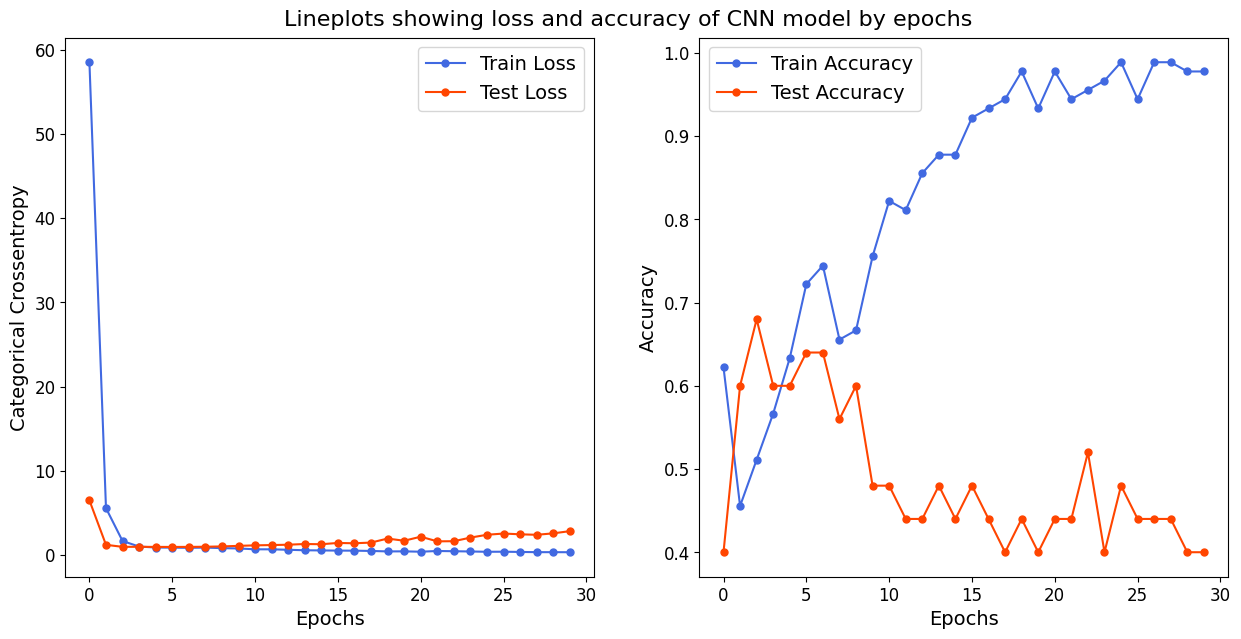

In [20]:
# plotting a line chart to visualize the loss and accuracy values by epochs

fig, ax = plt.subplots(ncols=2, figsize=(15,7))

ax = ax.ravel()

ax[0].plot(train_loss, label='Train Loss', color='royalblue', marker='o', markersize=5)
ax[0].plot(test_loss, label='Test Loss', color = 'orangered', marker='o', markersize=5)

ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)

ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)

ax[1].plot(train_accuracy, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
ax[1].plot(test_accuracy, label='Test Accuracy', color='orangered', marker='o', markersize=5)

ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)

ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)

fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss and accuracy of CNN model by epochs", fontsize=16)

## **Evaluation of the model**

In [22]:
# Evaluate the gender model on the test data
loss, accuracy = model.evaluate(x_test, y_test)

# Print the evaluation results
print(f'Test Loss: {loss:.2f}')
print(f'Test Accuracy: {accuracy:.2f}')

1/1 [==============================] - 0s 27ms/step - loss: 2.8335 - accuracy: 0.4000
Test Loss: 2.83
Test Accuracy: 0.40
